# Credit Risk Modeling | Part 1 – EDA & Business Context

This notebook is the first step in building a complete credit risk modeling pipeline, aligned with **Basel II regulatory standards**.  
We'll explore real loan application data to uncover risk segments, default patterns, and approval behaviors — laying the foundation for a robust and interpretable credit scorecard.

---

### 🧭 Business Case: LendingClub

You've joined the credit risk team at **LendingClub**, a leading US peer-to-peer lending platform.  
Your task is to analyze historical loan applications and determine which customer profiles are more likely to **default** on their loans.

---

### 🎯 Business Objectives

1. Explore and visualize customer-level risk patterns (EDA)
2. Build a **Probability of Default (PD)** model using WoE + Logistic Regression
3. Construct an interpretable **behavioral scorecard**
4. Monitor long-term **model stability** using PSI

---

### 📌 Key Concepts

- **PD (Probability of Default):** Likelihood that a borrower fails to repay a loan.
- **WoE (Weight of Evidence):** Helps create monotonic relationships between categorical variables and default probability.
- **PSI (Population Stability Index):** Tracks changes in the distribution of key variables over time to detect model drift.

---

### 🏦 Why Credit Risk Matters

When evaluating a loan application, a lender faces two main risks:
- Approving a high-risk borrower → financial loss
- Rejecting a low-risk borrower → lost business opportunity

A well-calibrated credit risk model helps the lender **optimize approvals**, **reduce losses**, and **comply with regulatory frameworks** like **Basel II**, which requires financial institutions to hold capital in proportion to exposure risk.

---

### 📚 Basel II Standards (Context)

The **Basel II Accord** requires banks to:
- Maintain adequate capital for risk coverage
- Undergo regular supervisory review
- Ensure transparency via market discipline

Retail exposures typically require a capital reserve of **75%** of total exposure under the standardized approach (SA), with more advanced approaches available (F-IRB, A-IRB).


# ⚙️EDA + Feature Engineering 

In [616]:
from utils import (
    plot_gradient_bar,
    save_and_display,
    plot_gradient_bar_grouped,
    plot_woe_distribution_plotly,
    plot_stacked_categorical_gradient,
    plot_pie
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings


warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## 1. Reading file

In [617]:
df=pd.read_csv('../data/accepted_loans.csv')
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68466916,NaN,25000.0,25000.0,25000.0,36 months,7.49,777.55,A,A4,Sales Manager,10+ years,MORTGAGE,109000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,226xx,VA,26.02,0.0,Dec-2001,745.0,749.0,1.0,NaN,NaN,9.0,0.0,20862.0,54.3,19.0,w,0.0,0.0,26224.230000,26224.23,25000.00,1224.23,0.0,0.00,0.0000,Sep-2016,20807.39,NaN,Apr-2017,724.0,720.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,305781.0,0.0,3.0,0.0,1.0,13.0,47194.0,58.0,0.0,1.0,8937.0,57.0,38400.0,1.0,0.0,1.0,2.0,33976.0,17538.0,54.3,0.0,0.0,142.0,168.0,13.0,13.0,3.0,13.0,NaN,0.0,NaN,0.0,3.0,3.0,5.0,6.0,7.0,5.0,9.0,3.0,9.0,0.0,0.0,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68446093,NaN,11550.0,11550.0,11550.0,60 months,16.59,284.51,D,D2,general manager,5 years,RENT,38000.0,Not Verified,Dec-2015,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,436xx,OH,21.07,0.0,Jan-2011,700.0,704.0,0.0,NaN,NaN,9.0,0.0,7179.0,39.7,12.0,w,0.0,0.0,7397.620000,7397.62,3184.23,3048.38,0.0,1165.01,209.7018,Nov-2017,284.51,NaN,Apr-2018,529.0,525.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,10353.0,1.0,2.0,0.0,1.0,13.0,3174.0,20.0,2.0,3.0,2701.0,30.0,18100.0,4.0,1.0,2.0,4.0,1150.0,6924.0,43.7,0.0,0.0,39.0,59.0,5.0,5.0,0.0,5.0,NaN,0.0,NaN,0.0,3.0,4.0,5.0,5.0,2.0,7.0,10.0,5.0,9.0,0.0,0.0,0.0,2.0,100.0,60.0,0.0,0.0,34105.0,10353.0,12300

In [618]:
df.shape

(50000, 151)

>Intially there are 151 variables, of which only a few are consistent and have real value

## 2. Identifying the target (y)
> dependent variable :
In our dataset the dependent variable js the "loan_status" column.
First we check what types of categories it can take, then map it values as follows: </br> 
>'Fully Paid', 'Current', 'In Grace Period'  - are map as '1' - **positive** </br>
>'Late (16-30 days)', 'Late (31-120 days)', 'Charged Off', 'Default' - are map with '0' - **negative**


In [619]:
# Define the mapping
loan_status_mapping = {
    'Fully Paid': 1,
    'Current': 1,
    'In Grace Period': 1,
    'Late (16-30 days)': 0,
    'Late (31-120 days)': 0,
    'Charged Off': 0,
    'Default': 0
}

# Apply the mapping to the 'Loan_Status' column
df['loan_status_binary'] = df['loan_status'].map(loan_status_mapping)
df.drop('loan_status', axis=1, inplace=True)

df['loan_status_binary'].value_counts()

loan_status_binary
1.0    43329
0.0     6621
Name: count, dtype: int64

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


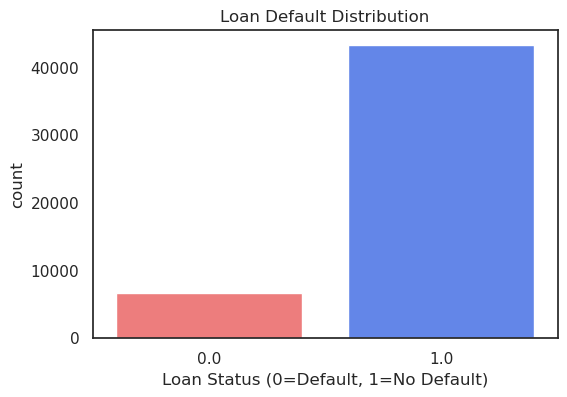

In [620]:
plt.figure(figsize=(6, 4))
# Simplemente le pasamos la columna y él cuenta solo
sns.countplot(x=df['loan_status_binary'], palette=['#ff6b6b', '#4d7cfe']) 
plt.title("Loan Default Distribution")
plt.xlabel("Loan Status (0=Default, 1=No Default)")
plt.show()


loan_status_binary
1.0    43329
0.0     6621
Name: count, dtype: int64


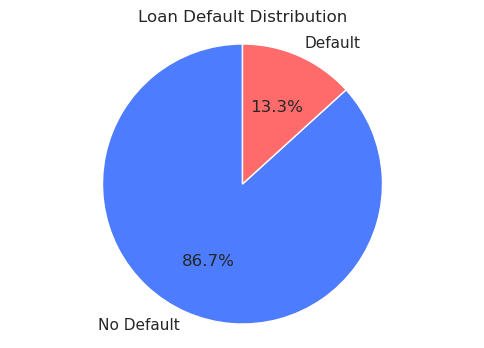

In [621]:
print(df['loan_status_binary'].value_counts())
plt.figure(figsize=(6, 4))
plt.pie(
    df['loan_status_binary'].value_counts(),
    labels=["No Default", "Default"],
    autopct="%1.1f%%",
    startangle=90,
    colors=["#4d7cfe", "#ff6b6b"]
)
plt.title("Loan Default Distribution")
plt.axis("equal")  # para que sea un círculo perfecto
plt.show()

###  Target Variable Distribution

>The target variable represents whether a loan applicant defaulted (0) or not (1).  
>This chart helps us understand class balance and assess whether special treatment (e.g., class weights, resampling) might be needed.


## 3. Missing values
> Check the missing values. columns that are missing by more than 35 percent will be removed.

In [622]:
def missing_data_summary(df, threshold=0):
    """
    Summarizes missing data, showing count and percentage of missing values for each column.
    Filters columns based on a missing percentage threshold.
    
    Parameters:
        df (pd.DataFrame): The dataframe to analyze.
        threshold (float): The minimum percentage of missing data to include in the summary.
    
    Returns:
        pd.DataFrame: A summary of missing data.
    """
    return (pd.DataFrame(df.isna().sum())
            .reset_index()
            .rename(columns={'index': 'Column', 0: 'mis_count'})
            .query('mis_count > 0')  # Only include columns with missing values
            .assign(Missing_Percentage=lambda x: x['mis_count'] / df.shape[0] * 100)
            .query(f'Missing_Percentage > {threshold}')  # Filter by threshold
            .sort_values('mis_count', ascending=False)
            .reset_index(drop=True))

missing = missing_data_summary(df, threshold = 35)
missing

,Column,mis_count,Missing_Percentage
0,member_id,50000,100.000
1,orig_projected_additional_accrued_interest,49831,99.662
2,hardship_dpd,49783,99.566
3,hardship_status,49783,99.566
4,deferral_term,49783,99.566
5,hardship_amount,49783,99.566
6,hardship_start_date,49783,99.566
7,hardship_end_date,49783,99.566
8,payment_plan_start_date,49783,99.566
9,hardship_length,49783,99.566


In [623]:
# Convert the first column of 'missing' to a list
columns_to_drop = missing.iloc[:, 0].tolist()

# Drop these columns from the DataFrame 'df'
df = df.drop(columns=columns_to_drop, errors='ignore')  # 'errors="ignore"' ensures no error if a column is missing

In [624]:
df.shape

(50000, 93)

>Only over a half have passed the filter of missing values because more they had a greater percentage of missing (or nan) values


###  Missing Data Summary

> To ensure the stability and reliability of the credit scoring model, we start by analyzing missing values. Excessive missing data in a variable can lead to biased models, distorted statistics, and misleading business decisions.

####  Key Actions:

* Columns with more than **35% missing data** have been removed.
* The chart below highlights the **top 10 features** with the highest proportion of missing values.
* Remaining features with moderate missing values will be imputed or engineered appropriately.

 *Note: Removing high-missing columns helps reduce noise, while imputing moderately incomplete data can preserve valuable signal for modeling.*


In [625]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 93 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          50000 non-null  int64  
 1   loan_amnt                   50000 non-null  float64
 2   funded_amnt                 50000 non-null  float64
 3   funded_amnt_inv             50000 non-null  float64
 4   term                        50000 non-null  object 
 5   int_rate                    50000 non-null  float64
 6   installment                 50000 non-null  float64
 7   grade                       50000 non-null  object 
 8   sub_grade                   50000 non-null  object 
 9   emp_title                   46380 non-null  object 
 10  emp_length                  46800 non-null  object 
 11  home_ownership              50000 non-null  object 
 12  annual_inc                  50000 non-null  float64
 13  verification_status         500

>Still there are several null values that will be corrected later. 

In [626]:
# threshold: more than 7 NaN values
threshold = 7
rows1 = df.shape[0]

df = df.dropna(thresh=threshold)

rows2 = df.shape[0]
print(f"Dropped {rows1 - rows2} rows with more than 7 missing values.")

df.shape

Dropped 0 rows with more than 7 missing values.


(50000, 93)

## 4. Categorical Features

In [627]:
df.select_dtypes(include=['object','int64', 'int32']).nunique()

id                      50000
term                        2
grade                       7
sub_grade                  35
emp_title               23206
emp_length                 11
home_ownership              6
verification_status         3
issue_d                   134
pymnt_plan                  2
url                     50000
purpose                    14
title                    2392
zip_code                  871
addr_state                 50
earliest_cr_line          628
initial_list_status         2
last_pymnt_d              126
last_credit_pull_d        114
application_type            2
hardship_flag               2
disbursement_method         2
debt_settlement_flag        2
dtype: int64

### Objects
> First let's check the 'object' columns. We see that there are some columns that can be transformed to date or numeric columns.

In [628]:
df.select_dtypes(include=['object']).head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,url,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,36 months,A,A4,Sales Manager,10+ years,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,226xx,VA,Dec-2001,w,Sep-2016,Apr-2017,Individual,N,Cash,N
1,60 months,D,D2,general manager,5 years,RENT,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,436xx,OH,Jan-2011,w,Nov-2017,Apr-2018,Individual,N,Cash,N
2,60 months,B,B3,Teacher,10+ years,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,660xx,KS,Nov-2003,w,Nov-2017,Nov-2017,Individual,N,Cash,N
3,36 months,C,C3,machine operation,3 years,OWN,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,282xx,NC,Nov-1994,w,Jul-2018,Aug-2018,Individual,N,Cash,N
4,60 months,D,D2,Flight Attendant,10+ years,RENT,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,891xx,NV,May-2002,w,Mar-2016,Mar-2019,Individual,N,Cash,N


>There are columns with too many values, lets erease them

In [629]:
columns_to_drop = {'title', 'zip_code', 'emp_title', 'url', 'id'}
df.drop(columns_to_drop, axis = 1, inplace = True)

In [630]:
# Remove leading/trailing whitespaces from objects
df = df.apply(lambda col: col.str.strip() if col.dtypes == 'object' else col)

import locale

# 1. Cambiamos la configuración regional a Inglés (para Windows)
# Esto permite que entienda 'Dec', 'Jan', etc.
try:
    locale.setlocale(locale.LC_TIME, 'English') 
except:
    # Si falla 'English', probamos con la configuración genérica de EEUU
    locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

# convert dates to 'datetime' types
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y')
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%Y')

# int_rate and revol_util for int type
# Convertimos a string primero (.astype(str)) para evitar el error si ya es numérico
df['int_rate%'] = pd.to_numeric(df['int_rate'].astype(str).str.strip('%'), errors='coerce')
df['revol_util%'] = pd.to_numeric(df['revol_util'].astype(str).str.strip('%'), errors='coerce')

columns_to_drop={'int_rate','revol_util'}
df.drop(columns_to_drop, axis = 1, inplace = True)

df.debt_settlement_flag = np.where(df.debt_settlement_flag == 'Y',1,0)

df.term_36_months = np.where(df.term == '36 months',1,0)
df.drop('term', axis=1, inplace=True)

df['emp_length'] = df['emp_length'].fillna('')
df['emp_length'] = pd.to_numeric(df['emp_length'].str.replace('<', '', regex=False).str[:2].str.strip(), errors='coerce')

df.hardship_flag.fillna('N', inplace=True) #it looks like the Nans are as strings so
df.hardship_flag = np.where( df.hardship_flag == 'NaN','N', df.hardship_flag )


In [631]:
def get_sorted_unique_counts(df):
    # Select columns with categorical data
    object_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Get the number of unique entries in each categorical column
    object_nunique = {col: df[col].nunique() for col in object_cols}
    
    # Convert to DataFrame and sort by unique counts
    unique_counts = pd.DataFrame(list(object_nunique.items()), columns=['Column', 'Unique Count'])
    unique_counts = unique_counts.sort_values(by='Unique Count').reset_index(drop=True)
    
    return unique_counts

get_sorted_unique_counts(df)

,Column,Unique Count
0,pymnt_plan,2
1,initial_list_status,2
2,application_type,2
3,hardship_flag,2
4,disbursement_method,2
5,verification_status,3
6,home_ownership,6
7,grade,7
8,purpose,14
9,sub_grade,35


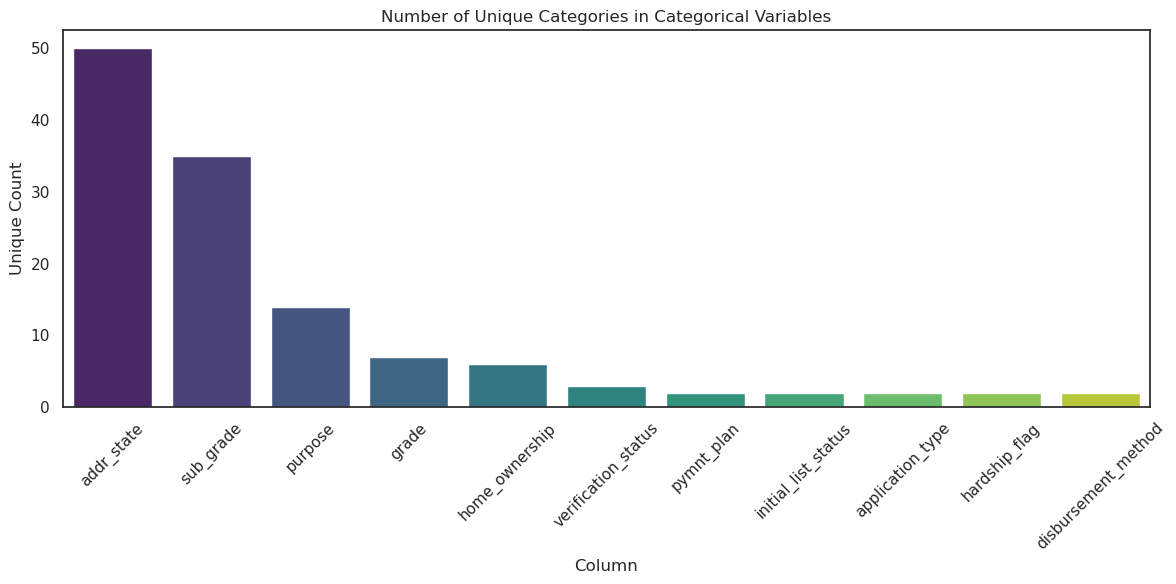

In [632]:
# 1. Calculamos los valores únicos por columna (solo las categóricas)
# Esto sustituye a tu función 'get_sorted_unique_counts'
unique_counts = df.select_dtypes(include=['object', 'category']).nunique().sort_values(ascending=False).reset_index()
unique_counts.columns = ['Column', 'Unique Count']

# 2. Graficamos con Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=unique_counts, x='Column', y='Unique Count', palette='viridis')

# Detalles estéticos básicos
plt.title("Number of Unique Categories in Categorical Variables")
plt.xticks(rotation=45) # Rotamos los nombres para que se lean bien
plt.tight_layout()
plt.show()


> Check how many unique values are in object columns. We check if binning is needed.
Check all for any inconsistences or imbalances

Imagen guardada como: distribution_purpose.png


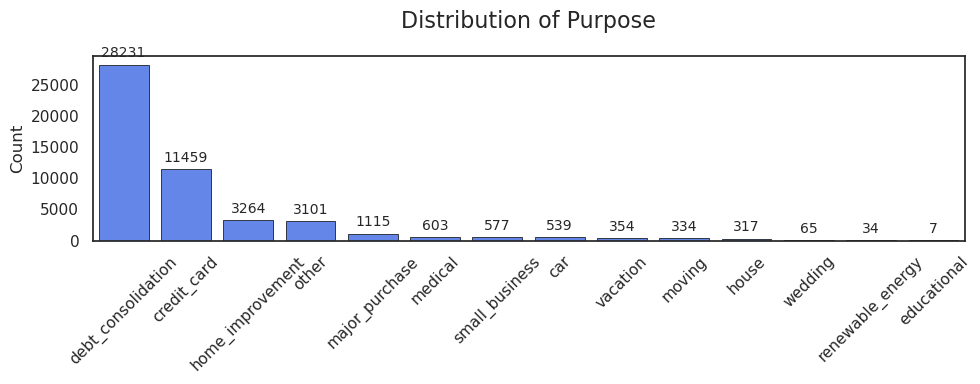

Imagen guardada como: distribution_purpose_pie.png


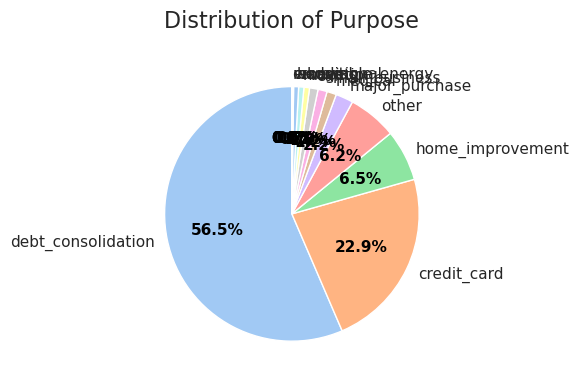

In [633]:
# PURPOSE
value_counts = df["purpose"].value_counts(dropna=False).sort_values(ascending=False)
labels = value_counts.index.astype(str).tolist()
values = value_counts.values.tolist()
gradients = [("#4d7cfe", "#97f3ff")] * len(labels)

fig = plot_gradient_bar(
    labels=labels,
    values=values,
    gradients=gradients,
    title="Distribution of Purpose",
    bar_width=0.55,
    height=400
)
save_and_display(fig, "distribution_purpose")

fig = plot_pie(
    labels=labels,
    values=values,
    title="Distribution of Purpose",
    height=400
)
save_and_display(fig, "distribution_purpose_pie")


Imagen guardada como: distribution_home_ownership.png


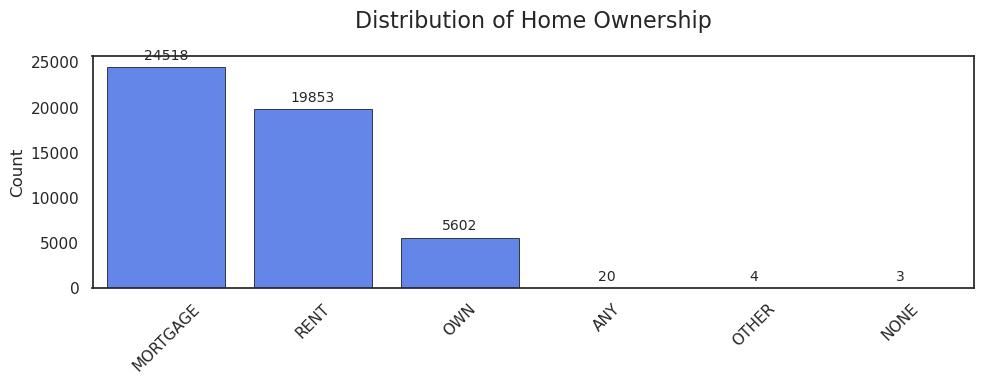

In [634]:
# HOME_OWNERSHIP
value_counts = df["home_ownership"].value_counts(dropna=False).sort_values(ascending=False)
labels = value_counts.index.astype(str).tolist()
values = value_counts.values.tolist()
gradients = [("#4d7cfe", "#97f3ff")] * len(labels)

fig = plot_gradient_bar(
    labels=labels,
    values=values,
    gradients=gradients,
    title="Distribution of Home Ownership",
    bar_width=0.55,
    height=400
)
save_and_display(fig, "distribution_home_ownership")


Imagen guardada como: distribution_application_type.png


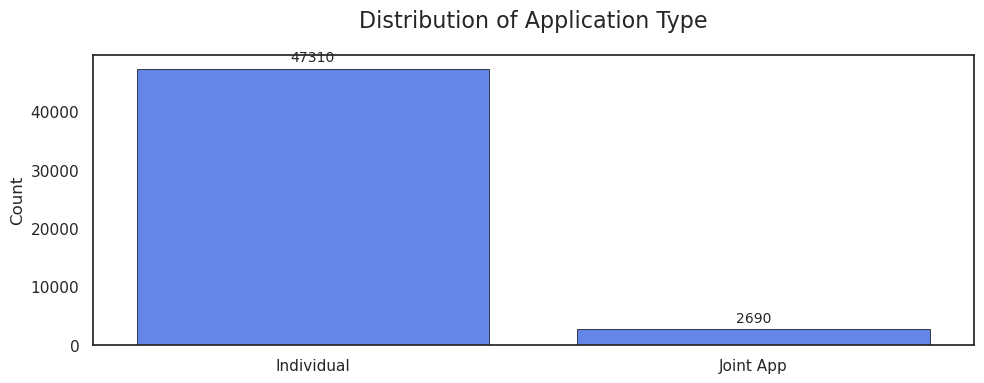

Imagen guardada como: distribution_application_type_pie.png


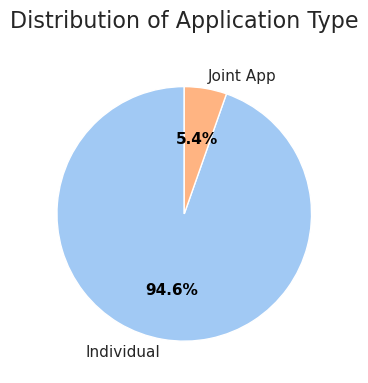

In [635]:
# APPLICATION_TYPE
value_counts = df["application_type"].value_counts(dropna=False).sort_values(ascending=False)
labels = value_counts.index.astype(str).tolist()
values = value_counts.values.tolist()
gradients = [("#4d7cfe", "#97f3ff")] * len(labels)

fig = plot_gradient_bar(
    labels=labels,
    values=values,
    gradients=gradients,
    title="Distribution of Application Type",
    bar_width=0.55,
    height=400
)
save_and_display(fig, "distribution_application_type")

fig2 = plot_pie(
    labels=labels,
    values=values,
    title="Distribution of Application Type",
    height=400
)
save_and_display(fig2, "distribution_application_type_pie")


In [636]:
def value_counter(df):
    value_series = pd.DataFrame()
    for col in df.select_dtypes(["object"]).columns:
        print(df[col].value_counts(dropna = False))

value_counter(df)

grade
B    14646
C    14408
A     9547
D     7219
E     3039
F      906
G      235
Name: count, dtype: int64
sub_grade
C1    3185
B5    3134
B4    3081
C2    2960
B3    2918
C3    2908
C4    2796
B1    2757
B2    2756
C5    2559
A5    2366
A4    2073
A1    1925
D1    1868
D2    1613
A3    1608
A2    1575
D3    1476
D4    1175
D5    1087
E1     749
E2     690
E3     605
E4     511
E5     484
F1     314
F2     199
F3     163
F4     119
F5     111
G1      79
G2      52
G4      39
G3      36
G5      29
Name: count, dtype: int64
home_ownership
MORTGAGE    24518
RENT        19853
OWN          5602
ANY            20
OTHER           4
NONE            3
Name: count, dtype: int64
verification_status
Source Verified    19521
Not Verified       16446
Verified           14033
Name: count, dtype: int64
pymnt_plan
n    49985
y       15
Name: count, dtype: int64
purpose
debt_consolidation    28231
credit_card           11459
home_improvement       3264
other                  3101
major_purchase       

In [637]:
# for col in df.select_dtypes(['object']).columns:
#     print(f"Column: {col}")
#     plot_pie(labels=df[col].value_counts(dropna=False)[0:].index.tolist(),
#              values=df[col].value_counts(dropna=False).values.tolist(),
#              title=f"Distribution of {col}",
#              height=400)
#     print("\n")

###  Key Observations on Categorical Variables

>  **`sub_grade`** is already hierarchically grouped via `grade`, so it may be redundant in modeling.
>
> **`home_ownership`** shows strong imbalance: `MORTGAGE` and `RENT` dominate, while `OWN` and especially `OTHER` are underrepresented. This can lead to **bias in classification models**, favoring majority classes. Consider combining sparse categories.
>
>  **`purpose`** has several rarely used categories such as `medical`, `vacation`, `wedding`, `renewable_energy`, and `educational`. These low-frequency classes might **increase model variance** and can be safely grouped under `"other"`.
>
>  **`addr_state`** has 51 unique values and might be too granular for most models. Possible actions:
>
> * Grouping by **US regions**
> * Creating **risk-level clusters**
> * Dropping if uninformative


In [638]:
df.drop('sub_grade', axis=1, inplace = True)

# 🔍Using WoE & IV for categorical features
>Now we will group categorical data based on Weight of Evidence (WoE) and create a table with relevant measures.
> **WoE**: WoE is computed as:<br>
> "Non-Event" - bad = '0' defaulted loans, <br>
> "Event"     - good = '1' non-default loans.<br>

$$
\text{WoE} = \ln\left(\frac{\text{Proportion of Non-Event}}{\text{Proportion of Event}}\right)
$$


> **IV (Information Value)** indicates the predictive power of the categorical variable. Total IV: Interpret the IV to understand the variable's predictive strength.

$$
\text{IV} = \sum \left( (\text{Proportion of Non-Event} - \text{Proportion of Event}) \cdot \text{WoE} \right)
$$

>Interpretation of IV:<br>
> < 0.02: Not Predictive <br>
> 0.02 - 0.1: Weak Predictive Power<br>
> 0.1 - 0.3: Medium Predictive Power<br>
> 0.3+: Strong Predictive Power<br>
> IV > 0.5: Suspiciously strong — Could indicate overfitting or data issues.

In [639]:
def process_categorical_columns(df, categorical_cols, target_col, woe_table=None, iv_summary=None, append=False):
    """
    Calculate WoE and IV for given categorical columns, including NaNs as a separate category.
    
    Args:
        df (pd.DataFrame): Input DataFrame.
        categorical_cols (list): List of categorical column names to process.
        target_col (str): Name of the binary target column (1 = Good, 0 = Bad).
        woe_table (pd.DataFrame): Existing WoE table (required if append=True).
        iv_summary (pd.DataFrame): Existing IV summary (required if append=True).
        append (bool): If True, append results to existing tables.
    
    Returns:
        woe_table (pd.DataFrame): WoE table with all processed columns.
        iv_summary (pd.DataFrame): IV summary table with all processed columns.
    """
    if append and (woe_table is None or iv_summary is None):
        raise ValueError("Existing tables must be provided when append=True.")
    
    # Initialize results if not appending
    if not append:
        woe_table = pd.DataFrame()
        iv_summary = pd.DataFrame()
    
    new_woe_results = []
    new_summary = []

    # Process each categorical column
    for col in categorical_cols:
        # Handle NaN values by creating a separate 'NaN' category
        df[col] = df[col].fillna('NaN')
        
        # Group by the column to calculate metrics
        stats = df.groupby(col).agg(
            event_count=(target_col, 'sum'),
            total_count=(target_col, 'count')
        ).reset_index()

        # Calculate non-event count and proportions
        stats['non_event_count'] = stats['total_count'] - stats['event_count']
        total_events = stats['event_count'].sum()
        total_non_events = stats['non_event_count'].sum()

        # Avoid division by zero
        stats['event_rate'] = stats['event_count'] / (total_events + 1e-6)
        stats['non_event_rate'] = stats['non_event_count'] / (total_non_events + 1e-6)

        # Calculate WoE
        stats['woe'] = np.log((stats['non_event_rate'] + 1e-6) / (stats['event_rate'] + 1e-6))
        
        # Calculate IV for each category
        stats['iv'] = (stats['non_event_rate'] - stats['event_rate']) * stats['woe']
        
        # Compute total IV for the column
        total_iv = stats['iv'].sum()

        # Add column name and rename for desired format
        stats['name'] = col  # Add column name
        stats.rename(columns={col: 'sub_name'}, inplace=True)  # Rename column to 'sub_name'
        
        # Reorder columns
        stats = stats[['name', 'sub_name', 'event_count', 'total_count', 'non_event_count', 
                       'event_rate', 'non_event_rate', 'woe', 'iv']]

        # Append results
        new_woe_results.append(stats)
        new_summary.append({'Column': col, 'IV': total_iv})

    # Combine results with existing tables if appending
    new_woe_table = pd.concat(new_woe_results, ignore_index=True)
    new_iv_summary = pd.DataFrame(new_summary).sort_values(by='IV', ascending=False)

    if append:
        woe_table = pd.concat([woe_table, new_woe_table], ignore_index=True)
        iv_summary = pd.concat([iv_summary, new_iv_summary], ignore_index=True).sort_values(by='IV', ascending=False)
    else:
        woe_table = new_woe_table
        iv_summary = new_iv_summary

    return woe_table, iv_summary

In [640]:
# Initial processing
categorical_cols = df.select_dtypes(include=['object']).columns
woe_table, iv_summary = process_categorical_columns(df, categorical_cols, 'loan_status_binary')

# Save initial results
# woe_table.to_csv('woe_table.csv', index=False)
# iv_summary.to_csv('iv_summary.csv', index=False)

iv_summary

,Column,IV
0,grade,0.469717
2,verification_status,0.078076
9,disbursement_method,0.062647
4,purpose,0.030179
1,home_ownership,0.026391
6,initial_list_status,0.023578
8,hardship_flag,0.018832
5,addr_state,0.018811
7,application_type,0.017514
3,pymnt_plan,0.017509


>A **FSS (Feature Subset Selection)** can be performed, extracting the variables below a certain IV value

In [ ]:
#dropping where IV < 0.02
# drop = {'application_type','initial_list_status','addr_state','purpose'}
# df.drop(drop, axis=1, inplace=True)

# df.drop({'application_type','initial_list_status', 'addr_state'}, axis=1, inplace=True)

In [642]:
print("Initial WoE Table:")
woe_table[woe_table.name == 'hardship_flag']

Initial WoE Table:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
86,hardship_flag,N,43329.0,49934,6605.0,1.0,0.997583,-0.002419,0.000006
87,hardship_flag,Y,0.0,16,16.0,0.0,0.002417,7.790511,0.018826


In [643]:
print("Initial WoE Table:")
woe_table[woe_table.name == 'verification_status']

Initial WoE Table:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
13,verification_status,Not Verified,14900.0,16417,1517.0,0.343881,0.229119,-0.406049,0.046599
14,verification_status,Source Verified,16835.0,19516,2681.0,0.388539,0.404924,0.041305,0.000677
15,verification_status,Verified,11594.0,14017,2423.0,0.267581,0.365957,0.313093,0.030801


In [644]:
print("Initial WoE Table:")
woe_table[woe_table.name == 'home_ownership']

Initial WoE Table:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
7,home_ownership,ANY,18.0,20,2.0,0.000415,0.000302,-0.317748,0.000036
8,home_ownership,MORTGAGE,21674.0,24501,2827.0,0.500219,0.426975,-0.158321,0.011596
9,home_ownership,NONE,3.0,3,0.0,0.000069,0.000000,-4.251885,0.000294
10,home_ownership,OTHER,3.0,3,0.0,0.000069,0.000000,-4.251885,0.000294
11,home_ownership,OWN,4878.0,5599,721.0,0.112580,0.108896,-0.033275,0.000123
12,home_ownership,RENT,16753.0,19824,3071.0,0.386646,0.463827,0.182001,0.014047


> As we see the WoE, IV and total counts numbers we can group the 'ANY', 'MORTGAGE' and 'NONE' together.

In [645]:
home_ownership_mapping = {
    'ANY' : 'other',
    'MORTGAGE' : 'mortgage',
    'RENT' : 'rent',
    'OWN' : 'own',
    'NONE' : 'other',
    'OTHER' : 'other'
}
df.home_ownership = df.home_ownership.map(home_ownership_mapping)

### 📊 Checking categorical features vs target

For a later, more complex study, `grade` variable can be eraised to be fairer. 

Imagen guardada como: stacked_grade.png


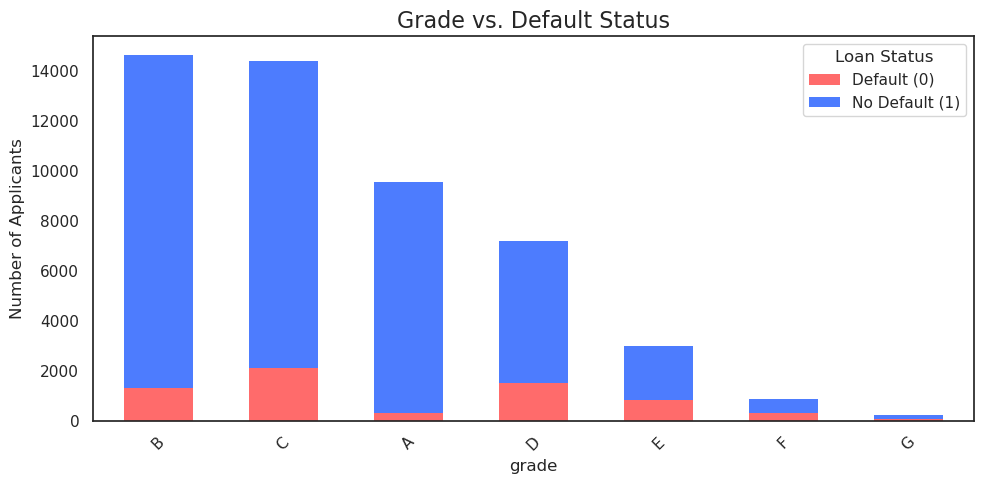

In [646]:
# GRADE
fig = plot_stacked_categorical_gradient(
    df,
    col="grade",
    title="Grade vs. Default Status",
    bar_width=0.55,
    height=500
)
save_and_display(fig, "stacked_grade")


Imagen guardada como: stacked_hardship_flag.png


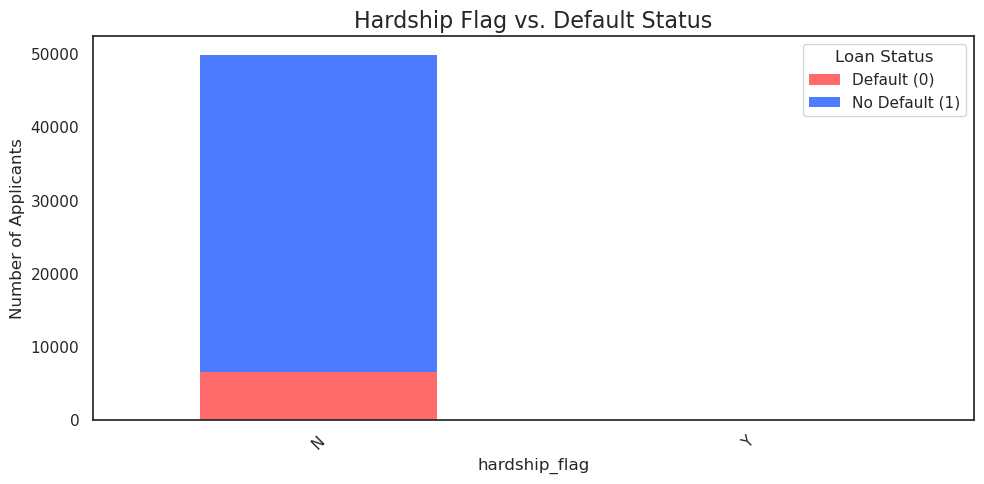

In [647]:
# HARDSHIP_FLAG
fig = plot_stacked_categorical_gradient(
    df,
    col="hardship_flag",
    title="Hardship Flag vs. Default Status",
    bar_width=0.55,
    height=500
)
save_and_display(fig, "stacked_hardship_flag")


In [648]:
df.drop('hardship_flag', axis=1, inplace=True)

Imagen guardada como: stacked_verification_status.png


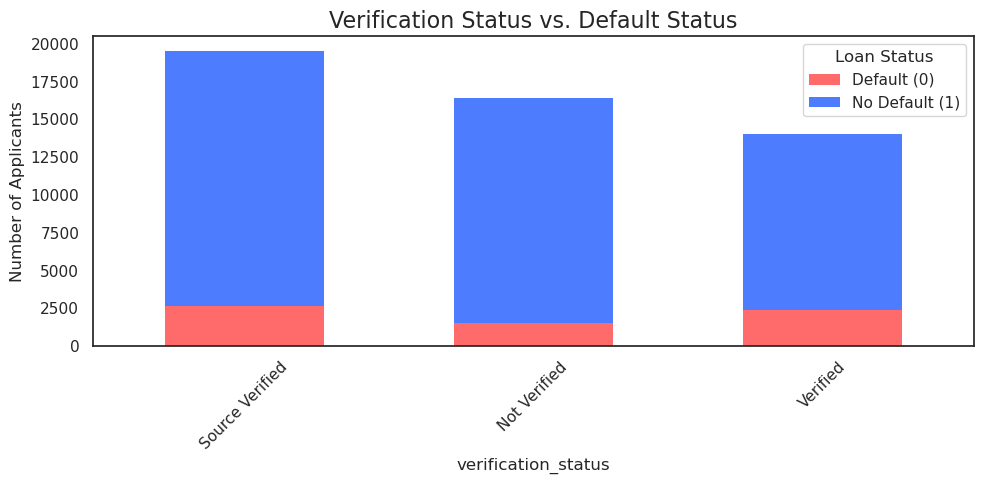

In [649]:
# VERIFICATION_STATUS
fig = plot_stacked_categorical_gradient(
    df,
    col="verification_status",
    title="Verification Status vs. Default Status",
    bar_width=0.55,
    height=500
)
save_and_display(fig, "stacked_verification_status")


Imagen guardada como: stacked_home_ownership.png


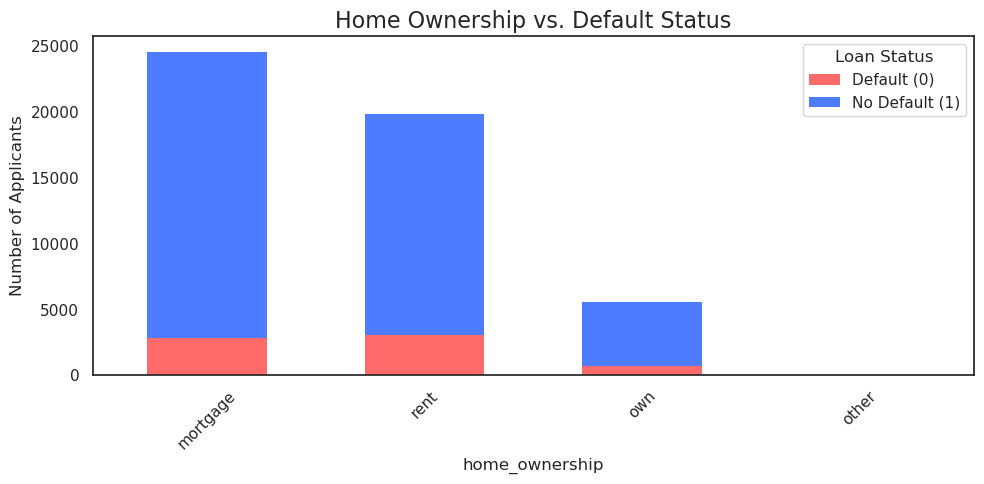

In [650]:
# HOME_OWNERSHIP
fig = plot_stacked_categorical_gradient(
    df,
    col="home_ownership",
    title="Home Ownership vs. Default Status",
    bar_width=0.55,
    height=500
)
save_and_display(fig, "stacked_home_ownership")


Imagen guardada como: stacked_addr_state.png


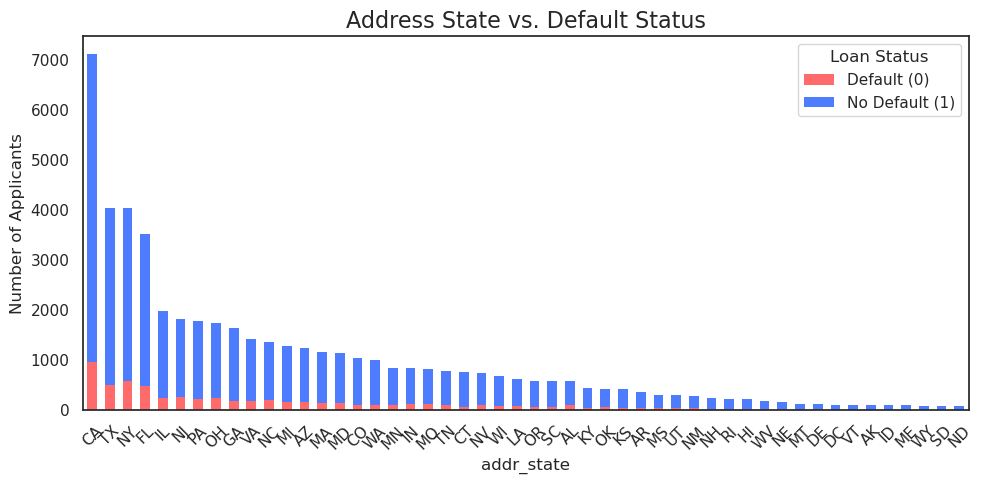

In [651]:
#STATE ADRESS
fig = plot_stacked_categorical_gradient(
    df,
    col="addr_state",
    title="Address State vs. Default Status",
    bar_width=0.55,
    height=500
)
save_and_display(fig, "stacked_addr_state")

Imagen guardada como: stacked_purpose.png


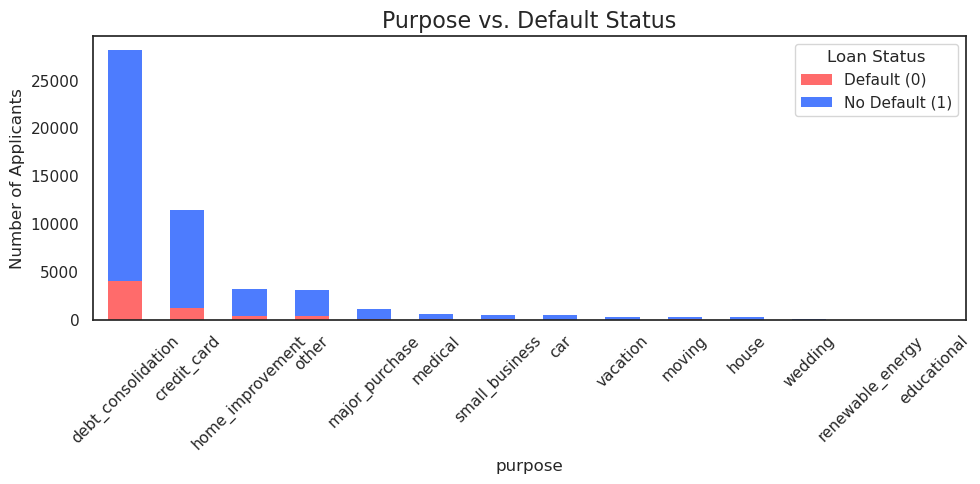

In [652]:
#PURPOSE
fig = plot_stacked_categorical_gradient(
    df,
    col="purpose",
    title="Purpose vs. Default Status",
    bar_width=0.55,
    height=500
)
save_and_display(fig, "stacked_purpose")

Imagen guardada como: stacked_application_type.png


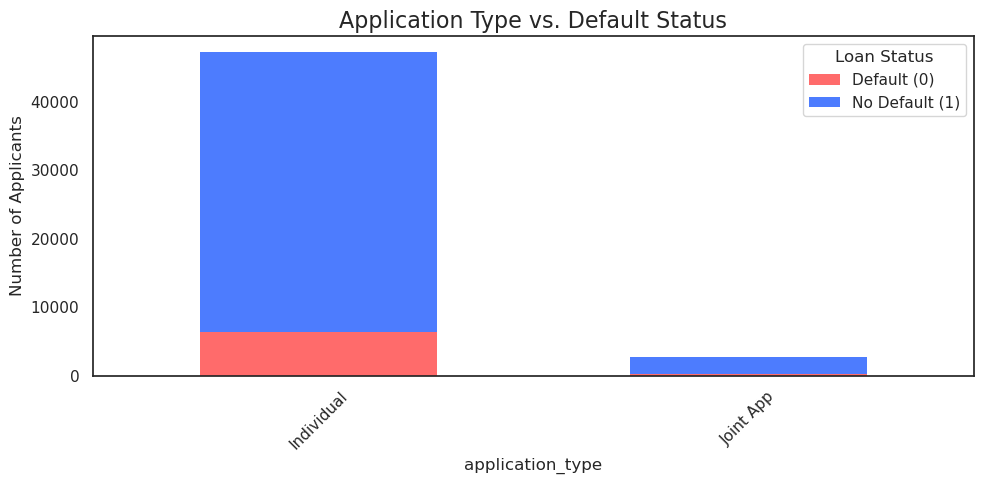

In [653]:
#APPLICATION TYPE
fig = plot_stacked_categorical_gradient(
    df,
    col="application_type",
    title="Application Type vs. Default Status",
    bar_width=0.55,
    height=500
)
save_and_display(fig, "stacked_application_type")

Imagen guardada como: stacked_initial_list_status.png


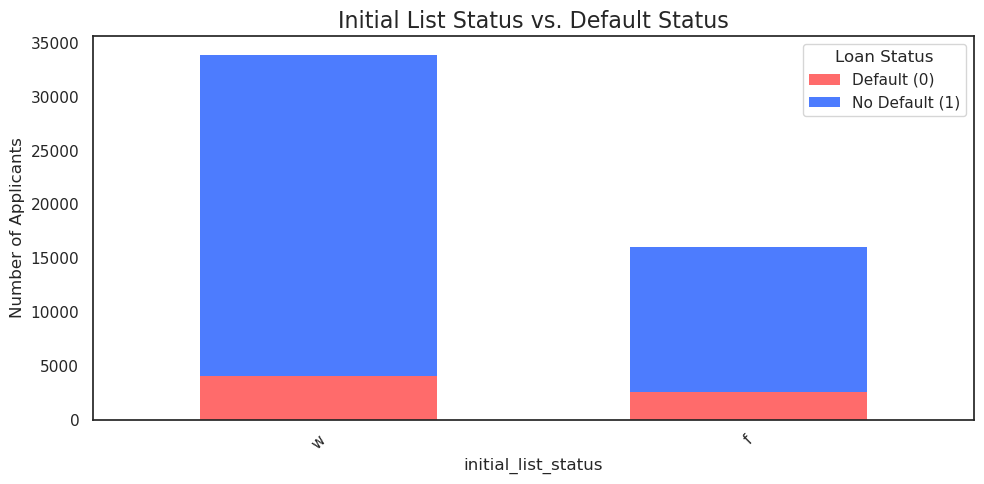

In [654]:
#INITIAL LIST STATUS
fig = plot_stacked_categorical_gradient(
    df,
    col="initial_list_status",
    title="Initial List Status vs. Default Status",
    bar_width=0.55,
    height=500
)
save_and_display(fig, "stacked_initial_list_status")

## 5. Date features

>Date columns often contain valuable temporal information that can improve predictive modeling. Lets extract meaningful features from these date columns.



In [655]:
date_cols = df.select_dtypes(include=['datetime64']).columns
df[date_cols].head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,2015-12-01,2001-12-01,2016-09-01,2017-04-01
1,2015-12-01,2011-01-01,2017-11-01,2018-04-01
2,2015-12-01,2003-11-01,2017-11-01,2017-11-01
3,2015-12-01,1994-11-01,2018-07-01,2018-08-01
4,2015-12-01,2002-05-01,2016-03-01,2019-03-01


In [656]:
df[date_cols].isna().sum()

issue_d                0
earliest_cr_line       0
last_pymnt_d          52
last_credit_pull_d     1
dtype: int64

In [657]:
from datetime import datetime

# Assuming 'today' as the current date
today = pd.to_datetime("today")

#impute a today date to distinguish missing values.
df['last_pymnt_d'].fillna(today, inplace=True)
df['last_credit_pull_d'].fillna(today, inplace=True)

# Time differences
df['loan_age'] = (today - df['issue_d']).dt.days
df['credit_history_length'] = (df['issue_d'] - df['earliest_cr_line']).dt.days
df['time_since_last_payment'] = (today - df['last_pymnt_d']).dt.days
df['time_since_last_credit_pull'] = (today - df['last_credit_pull_d']).dt.days

# Temporal components
df['issue_year'] = df['issue_d'].dt.year
df['issue_month'] = df['issue_d'].dt.month

# Categorical flags
df['recent_payment'] = (df['time_since_last_payment'] <= 30).astype(int)
df['recent_credit_pull'] = (df['time_since_last_credit_pull'] <= 90).astype(int)

drop = {'issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d'}
df.drop(drop,axis=1, inplace=True)

In [658]:
df.shape

(50000, 89)

## 6. Numeric Features

In [659]:
y = df.loan_status_binary
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(exclude=['object']).drop('loan_status_binary',axis=1).columns

# Concatenate numeric columns explicitly
df_final = pd.concat([df[num_cols], df[cat_cols]], axis=1)
# df_final = pd.concat([df[num_cols], pd.get_dummies(df[cat_cols], drop_first=True)], axis=1)

>Remove external scores

In [660]:
external_scores = {'last_fico_range_high','last_fico_range_low','fico_range_low', 'fico_range_high'}
num_cols = [col for col in num_cols if col not in external_scores]
df_final.drop(external_scores , axis=1, inplace=True)

For the missing values apply `simple imputer`. It fill with the variable mean the missing values in each column. (Only numerical variables).

In [661]:
from sklearn.impute import SimpleImputer

# Define imputer (mean for numeric features, most frequent for categorical)
imputer = SimpleImputer(strategy='mean')

# Apply imputation to X
X_imputed = imputer.fit_transform(df_final[num_cols])

# Convert back to DataFrame if necessary
df_final = pd.DataFrame(X_imputed, columns=df_final[num_cols].columns)


1. Correlation Analysis
Identify features strongly correlated with the target variable.

In [662]:
# Compute the absolute correlations
correlations = df_final.corrwith(y).abs()

# Convert to DataFrame and sort
correlation_df = correlations.sort_values(ascending=False).reset_index()
correlation_df.columns = ['name', 'correlation']

# Display the resulting DataFrame
correlation_df.head(30)

,name,correlation
0,recoveries,0.492235
1,collection_recovery_fee,0.460466
2,debt_settlement_flag,0.316002
3,total_rec_prncp,0.238553
4,int_rate%,0.206523
5,time_since_last_payment,0.196585
6,last_pymnt_amnt,0.193686
7,time_since_last_credit_pull,0.187435
8,out_prncp,0.171962
9,out_prncp_inv,0.171943


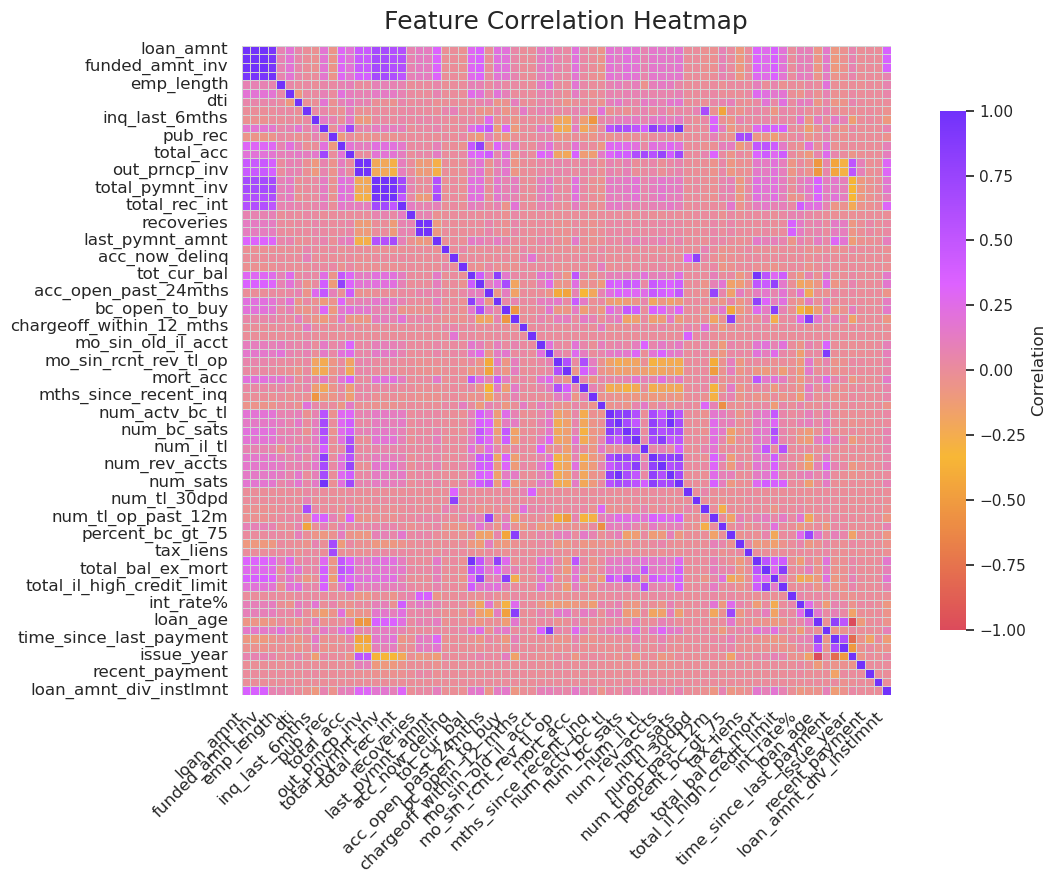

In [674]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


colors = ["#dc4b5b", "#f7b736", "#dd62ff", "#7132fb"]
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", colors, N=256)


feature_corr = df_final.select_dtypes(exclude=['object']).corr(method='pearson')


mask = (feature_corr.abs() > 0.5).any(axis=1)
filtered_corr = feature_corr.loc[mask, mask]


plt.figure(figsize=(12, 9))
sns.set(font="DejaVu Sans", style="white", rc={"axes.facecolor": "white"})

sns.heatmap(
    filtered_corr,
    cmap=custom_cmap,
    center=0,
    linewidths=0.5,
    linecolor='lightgray',
    square=True,
    annot=False,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
    vmin=-1, vmax=1
)

plt.title("Feature Correlation Heatmap", fontsize=18, pad=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



>The heatmap above displays the most relevant correlations between features (|corr| > 0.5), allowing for better visibility and interpretability.


In [664]:
# Identify pairs of highly correlated features
threshold = 0.8
high_corr_pairs = feature_corr.abs().stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]
high_corr_pairs = high_corr_pairs[high_corr_pairs[0] > threshold]
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs

,Feature1,Feature2,Correlation
1,loan_amnt,funded_amnt,0.999751
2,loan_amnt,funded_amnt_inv,0.998873
3,loan_amnt,installment,0.945499
74,funded_amnt,loan_amnt,0.999751
76,funded_amnt,funded_amnt_inv,0.999198
...,...,...,...
4993,credit_history_length,mo_sin_old_rev_tl_op,0.903816
5098,time_since_last_payment,loan_age,0.807779
5102,time_since_last_payment,issue_year,0.802404
5246,issue_year,loan_age,0.987430


>As Bayes Networks are going to be used, a **discretization** will be aplied.

In [665]:
df.to_csv('../data/processed_loans.csv', index=False)

# 📊Feature selection & training

### 🚀 Feature Selection & Preprocessing Pipeline for Bayesian Network

> Highly correlated features can lead to redundancy, multicollinearity, and reduced model interpretability.
> We already checked correlation with target:  Pearson correlation with the target variable to rank features,correlation matrix heatmap. 
> There is a way to drop one feature from each highly correlated pair (e.g., |correlation| > 0.8) using domain knowledge.

### 📋 Process Workflow

1.  **Initial Numerical Screening (Pearson Correlation):**
    * Perform a baseline check on raw numerical features using **Pearson Correlation**.
    * *Goal:* Identify obvious redundancies before transformation.

2.  **Feature Uniformity (Discretization & Encoding):**
    * **Numerical Variables:** Transformed into discrete bins using `KBinsDiscretizer` (Quantile strategy). This handles outliers naturally and linearizes relationships.
    * **Categorical Variables:** Encoded into numerical indices using `LabelEncoder`.
    * **Outcome:** All features are now in a homogeneous discrete format, which is the required input for **Bayesian Networks**.

3.  **Predictive Power Assessment (Mutual Information Gain):**
    * Calculate the **Mutual Information (MI)** score for every feature against the target variable (`loan_status`).
    * MI captures any kind of statistical dependency (linear or non-linear), providing a universal metric to compare numerical and categorical data.

4.  **Redundancy Filtering (The "MI-Duel" Logic):**
    * Iterate through features ranked by MI.
    * For pairs with a high **Spearman Correlation** (> 0.8), we keep the feature with the higher MI score and discard the redundant one.
    * **Result:** A clean feature set where every variable provides unique, high-value information.

5.  **Optimal Subset Selection (Knee Plot Analysis):**
    * Generate a **Knee Plot** (Scree plot) of the sorted MI scores.
    * Identify the "elbow" point to determine the optimal number of features, balancing model complexity with predictive performance.

### 🛠️ Key Algorithms (Python Implementation)

| Step | Algorithm/Function | Library |
| :--- | :--- | :--- |
| **Correlation** | `.corr(method='pearson')` | `pandas` |
| **Discretization** | `KBinsDiscretizer(strategy='quantile')` | `scikit-learn` |
| **Feature Scoring** | `mutual_info_classif(discrete_features=True)` | `scikit-learn` |
| **Structure Learning** | `HillClimbSearch` | `pgmpy` |

---

## 1. Selection based on correlation

In [666]:
# Create a set to store features to drop
features_to_drop = set()

# Iterate through each pair of highly correlated features
for _, row in high_corr_pairs.iterrows():
    feature1 = row['Feature1']
    feature2 = row['Feature2']
    
    # Get the correlation with the target for both features
    corr1 = correlation_df[correlation_df['name'] == feature1]['correlation'].values[0]
    corr2 = correlation_df[correlation_df['name'] == feature2]['correlation'].values[0]
    
    # Drop the feature with lower correlation with the target
    if corr1 >= corr2:
        features_to_drop.add(feature2)
    else:
        features_to_drop.add(feature1)

# Drop features from your dataset
selected_features = [col for col in feature_corr.columns if col not in features_to_drop]

# Print the results
print(f"Features to drop: {features_to_drop}")
print(f"Remaining features: {len(selected_features)}")

Features to drop: {'credit_history_length', 'avg_cur_bal', 'total_bal_ex_mort', 'num_rev_tl_bal_gt_0', 'collection_recovery_fee', 'loan_amnt', 'total_bc_limit', 'bc_util', 'num_op_rev_tl', 'num_sats', 'num_bc_sats', 'open_acc', 'loan_age', 'revol_util%', 'funded_amnt_inv', 'tot_cur_bal', 'issue_year', 'num_bc_tl', 'num_actv_bc_tl', 'funded_amnt', 'total_pymnt_inv', 'num_tl_30dpd', 'total_pymnt', 'out_prncp_inv'}
Remaining features: 51


> From highly correlated features  loan-amount and installment lets do a one new feature

In [667]:
df_final['loan_amnt_div_instlmnt']=df_final['loan_amnt']/df_final['installment']
features_to_drop.add('installment')

In [668]:
df_final_fss = df_final.copy()
df_final_fss.drop(features_to_drop, axis=1, inplace=True)

In [669]:
df_final.shape

df_final_fss.to_csv('../data/FSS_correlationbased_loans.csv', index=False)

## 2. Further features selection with RFE

In [670]:
X = df_final

In [671]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

RESULT: 'out_prncp', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt',
       'debt_settlement_flag', 'int_rate%', 'loan_age',
       'time_since_last_payment', 'time_since_last_credit_pull',
       'loan_amnt_div_instlmnt'

In [ ]:
print(df['loan_status_binary'].value_counts())

# 💠Training Models 

In [ ]:
# Define a function to evaluate and display metrics
def evaluate_model(model, X_test, y_test, model_name):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    print(f"Results for {model_name}:")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\n")
    
    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Recall": recall,
        "F2": f2,
        "AUC": auc
    }



# 💠Bayesian Network

In [ ]:
import networkx as nx

from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.metrics import structure_score

# Configuración visual para que los gráficos salgan grandes y limpios
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

ImportError: cannot import name 'BDeuScore' from 'pgmpy.estimators' (c:\Users\sergi\anaconda3\envs\ml\Lib\site-packages\pgmpy\estimators\__init__.py)

##  1. Logistic Regression
##  2. Random Forest
##  3. Gradient Boost
##  4. Neural Networks

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, recall_score, fbeta_score, roc_auc_score,
    classification_report, RocCurveDisplay)

# Logistic Regression Model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Random Forest Model
rf_soft = RandomForestClassifier(n_estimators=100, random_state=42)
rf_soft.fit(X_train_scaled, y_train)

# Gradient Boosting Model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Neural Network Model
nn_model = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=300, random_state=42, solver='adam')
nn_model.fit(X_train_scaled, y_train)

# Update the evaluation code to include all four models
results = []
results.append(evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression"))
results.append(evaluate_model(rf_soft, X_test_scaled, y_test, "Random Forest"))
results.append(evaluate_model(gb_model, X_test_scaled, y_test, "Gradient Boosting"))
results.append(evaluate_model(nn_model, X_test_scaled, y_test, "Neural Network"))

# Plot ROC Curves for all models
plt.figure(figsize=(4, 4))
RocCurveDisplay.from_estimator(lr_model, X_test_scaled, y_test, name="Logistic Regression")
RocCurveDisplay.from_estimator(rf_soft, X_test_scaled, y_test, name="Random Forest")
RocCurveDisplay.from_estimator(gb_model, X_test_scaled, y_test, name="Gradient Boosting")
RocCurveDisplay.from_estimator(nn_model, X_test_scaled, y_test, name="Neural Network")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

# Summarize the results in a DataFrame

results_df = pd.DataFrame(results)
print("Summary of Results:")
print(results_df)


# 📜Conclusion
> The Neural Network and Random Forest model has quite good scores! We could check a different thresholds to see if the FP and FN can have a better results. Of course we need Logistic Regression due to interpretability.
> <br>
> In next notebook we will create a behavioral scorecard: the general framework involves setting score ranges and corresponding risk groups (e.g., high-risk, medium-risk, low-risk) based on statistical analysis and business policies.<br>
> To not interupt the code and make the steps clear I'm saving the important results:<br>
> * Logistic Regresion model - trade off between score and interpretability <br>
> * Neural Network  model<br>
> * Random Forest model<br>
> * data after cleaning with selected features.<br>
Everything here:<br>
https://www.kaggle.com/datasets/beatafaron/loan-credit-risk-and-population-stability


# 🎯Next Steps
> Here is direct link to next steps: <br>
> 2. Behavioral Scorecards, weight of evidence, logistic regresion.
> https://www.kaggle.com/code/beatafaron/complete-credit-risk-modeling-2-sc-woe
> <br>
> 3. Population stability index.<br>
> https://www.kaggle.com/code/beatafaron/complete-credit-risk-modeling-3-psi

In [ ]:
# save models for later

In [ ]:
import joblib  
# Save the NN model to a file
#joblib.dump(nn_model, 'nn_model_model.pkl')

# Save the RF model to a file
#joblib.dump(rf_soft, 'rf_soft_model.pkl')

# Save the LR model to a file
#joblib.dump(lr_model, 'lr_model.pkl')

# save scaler for later
#joblib.dump(scaler, "scaler.pkl")

# Save df_final to a CSV file
df_final = df_final[selected_features_names]
df_final.to_csv("df_2014-18_selected.csv", index=False)